# A tour of Machine Learning Clasifiers Using scikit-learn
En este capitulo se revisara una coleccion popular de algoritmos de machine learning. Interactuaremos por primera vez con la biblioteca **sickit-learn** y veremos algunos algoritmos de aprendizaje supervisado para clasificacion. 

### Como elegir un algortimo de clasificacion
Elegir un algoritmos de clasificacion para un problema en particular requiere practica y experiencia. Cada algoritmos tiene sus pros y sus contra asi como cada uno esta basado en diferentes hipotesis sobre los datos.

Los diferentes algoritmos pueden varias en cantidad e features necesarias, ruido en el dataset, si las clases a a clasificar son linealmente separables etc. En general, los principales pasos que estan involucrados en entrenar un algoritmo supervisado de ML son:

1. Seleccionar las features y recolectar ejemplos para el entrenamiento
2. Elegir una metrica de perfomance
3. Elegir un algoritmos y entrenar el modelo
4. Evaluar la perfomance del modelo
5. Cambiar la configuracion para mejorar el modelo

##  First steps with scikit-learn – training a perceptron

Vamos a hacer algo parecido a lo que hicimos el capitulo anterior y vamos entrenar un perceptron. Pero esta vez en lugar de armarlo desde 0 utilizando Numpy vamos a utilizar la biblioteca de scikit-learn.

In [3]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [29]:
#Para poder ver que tan bien funciona el modelo vamos a separar el dataset en train test,
#una metodolgia que se vera con mas profundidad en el capitulo 6

from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.3, random_state= 1, stratify= y #Este parametro asegura la misma proporcion de labes en ambos datasets
)   

In [30]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


Muchos algoritmos de ML siguen ciertas hipotesis acerca de sus datos para poder funcionar de manera correcta, es este caso estandarizaremos los datos utilizando el **StandarScaler** de scikit lear.


In [31]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

Una vez estandarizados nuestros datos vamos a importar el perceptron y entrenarlo con nuestros datos. Por default muchos modelos de SK vienen con el tipo de clasificacion conocido como **one-versus-rest**

In [32]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.01, random_state=1)
ppn.fit(X_train_sc,y_train)

Perceptron(eta0=0.01, random_state=1)

In [33]:
y_pred = ppn.predict(X_test_sc)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 2


In [34]:
#Existen otras metricas que uno podria revisar de un modelo, como la accuracy.
from sklearn.metrics import accuracy_score
print("Accuracy: %.3f"% accuracy_score(y_test,y_pred))

Accuracy: 0.956


In [35]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
 # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
 # highlight test examples
    if test_idx:
 # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

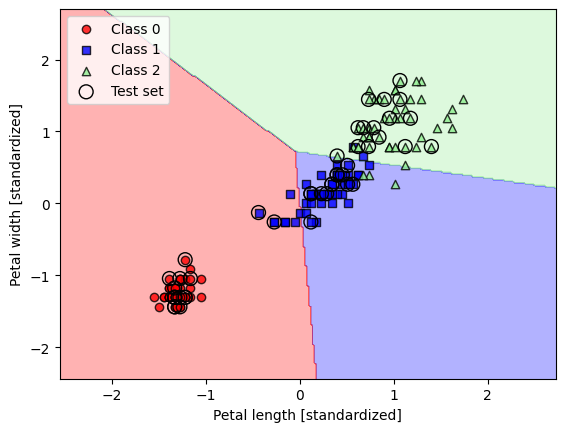

In [36]:
X_combined_std = np.vstack((X_train_sc, X_test_sc))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                       y=y_combined,
                       classifier=ppn,
                       test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')


## Modeling class probabilites via logistic regression